# Load Data


In [1]:
!unzip /content/quora-question-pairs.zip 

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [2]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [12]:
import pandas as pd

In [66]:
# X_train = pd.read_csv('/content/train.csv')
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [78]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [79]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Stop Words

In [6]:
import nltk
from nltk.corpus import stopwords

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
stop_words = set(stopwords.words("english"))

In [73]:
def word_match(row):
  q1words = {}
  q2words = {}

  # remove stop words

  # Question 1
  for word in str(row[3]).lower().split():
  #for word in row['question1']:
    if word not in stop_words:
      q1words[word] = 1
  # Question 2
  for word in str(row[4]).lower().split():
    if word not in stop_words:
      q2words[word] = 1

  if len(q1words) == 0 or len(q2words) == 0:
    return 0

  # count shared words in questions
  q1_shared_word = [w for w in q1words.keys() if w in q2words]
  q2_shared_word = [w for w in q2words.keys() if w in q1words]

  shared = (len(q1_shared_word) + len(q2_shared_word))/(len(q1words) + len(q2words))
  return shared

In [29]:
match = X_train.apply(word_match, axis=1, raw=True)

In [24]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'word matches')

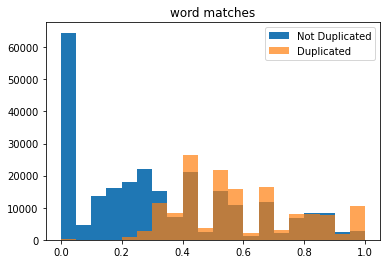

In [30]:
plt.figure()
plt.hist(match[X_train['is_duplicate']==0], bins=20, label='Not Duplicated')
plt.hist(match[X_train['is_duplicate']==1], bins=20, alpha=0.7, label='Duplicated')
plt.legend()
plt.title('word matches')

From here, we see that duplicated question pairs tend to have more shared word among the questions.

# TF-IDF

First let's get the weight for the quesions words

In [40]:
X_train['question1'] = X_train['question1'].map(lambda x: str(x).lower().split())
X_train['question2'] = X_train['question2'].map(lambda x: str(x).lower().split())

In [41]:
train_qs = pd.Series(X_train['question1'].tolist() + X_train['question2'].tolist())

In [42]:
words = [x for y in train_qs for x in y]

In [44]:
from collections import Counter

In [45]:
counts = Counter(words)

In [36]:
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

In [46]:
weights = {word: get_weight(count) for word, count in counts.items()}

In [50]:
# let's see what are the most commonly seen words in our training dataset
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

# and most uncommon ones?
print(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]
[('シ', 9.998000399920016e-05), ('し?', 9.998000399920016e-05), ('19-year-old.', 9.998000399920016e-05), ('1-855-425-3768', 9.998000399920016e-05), ('confederates', 9.998000399920016e-05), ('asahi', 9.998000399920016e-05), ('fab', 9.998000399920016e-05), ('109?', 9.998000399920016e-05), ('samrudi', 9.998000399920016e-05), ('fulfill?', 9.998000399920016e-05)]


In [55]:
import numpy as np

In [74]:
# now let's try tf-idf
def tfidf_word_match(row):
  q1words = {}
  q2words = {}

  # question 1
  for word in str(row[3]).lower().split():
    if word not in stop_words:
      q1words[word] = 1
  # question 2
  for word in str(row[4]).lower().split():
    if word not in stop_words:
      q2words[word] = 1

  if len(q1words) == 0 or len(q2words) == 0:
    return 0

  shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
  total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]

  shared = np.sum(shared_weights) / np.sum(total_weights)
  return shared

In [64]:
tfidf_match = X_train.apply(tfidf_word_match, axis=1, raw=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'word matches')

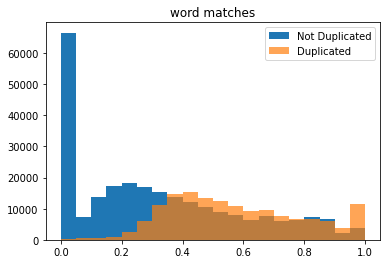

In [65]:
plt.figure()
plt.hist(tfidf_match[X_train['is_duplicate']==0].fillna(0), bins=20, label='Not Duplicated')
plt.hist(tfidf_match[X_train['is_duplicate']==1].fillna(0), bins=20, alpha=0.7, label='Duplicated')
plt.legend()
plt.title('word matches')


# Data Pre-processing

In [95]:
from sklearn.model_selection import train_test_split

In [82]:
def word_match_test(row):
  q1words = {}
  q2words = {}

  # remove stop words

  # Question 1
  for word in str(row[1]).lower().split():
  #for word in row['question1']:
    if word not in stop_words:
      q1words[word] = 1
  # Question 2
  for word in str(row[2]).lower().split():
    if word not in stop_words:
      q2words[word] = 1

  if len(q1words) == 0 or len(q2words) == 0:
    return 0

  # count shared words in questions
  q1_shared_word = [w for w in q1words.keys() if w in q2words]
  q2_shared_word = [w for w in q2words.keys() if w in q1words]

  shared = (len(q1_shared_word) + len(q2_shared_word))/(len(q1words) + len(q2words))
  return shared

In [83]:
def tfidf_word_match_test(row):
  q1words = {}
  q2words = {}

  # question 1
  for word in str(row[1]).lower().split():
    if word not in stop_words:
      q1words[word] = 1
  # question 2
  for word in str(row[2]).lower().split():
    if word not in stop_words:
      q2words[word] = 1

  if len(q1words) == 0 or len(q2words) == 0:
    return 0

  shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
  total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]

  shared = np.sum(shared_weights) / np.sum(total_weights)
  return shared

In [84]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()

x_train['word_match'] = match
x_train['tfidf_word_match'] = tfidf_match

x_test['word_match'] = df_test.apply(word_match_test, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_test, axis=1, raw=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [85]:
y_train = df_train['is_duplicate'].values

In [86]:
pos_train = x_train[y_train==1]
neg_train = x_train[y_train==0]

In [87]:
print(len(pos_train))
print(len(neg_train))

149263
255027


In [89]:
p = 0.165
scale = ((len(pos_train)/(len(pos_train)+len(neg_train)))/p) - 1

In [90]:
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])

In [92]:
# update x_train & y_train
x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()

In [120]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.33, random_state=0)

# XGBoost Model

In [145]:
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score

In [98]:
# hyper-parameter
params = {
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'eta':0.02,
    'max_depth':4,
    'subsample':0.8,
    'base_score':0.2
}

In [102]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_validation = xgb.DMatrix(x_validation, label=y_validation)

In [103]:
watchlist = [(d_train, 'train'), (d_validation, 'validation')]

In [104]:
model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.682615	validation-logloss:0.683035
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602738	validation-logloss:0.602171
[20]	train-logloss:0.545731	validation-logloss:0.545247
[30]	train-logloss:0.503673	validation-logloss:0.503479
[40]	train-logloss:0.472941	validation-logloss:0.472397
[50]	train-logloss:0.44863	validation-logloss:0.448781
[60]	train-logloss:0.430666	validation-logloss:0.430557
[70]	train-logloss:0.416436	validation-logloss:0.416313
[80]	train-logloss:0.405659	validation-logloss:0.405183
[90]	train-logloss:0.396932	validation-logloss:0.396532
[100]	train-logloss:0.390227	validation-logloss:0.389638
[110]	train-logloss:0.384431	validation-logloss:0.384353
[120]	train-logloss:0.380661	validation-logloss:0.380043
[130]	train-logloss:0.377134	validation-logloss:0.376473
[140]	train-logloss:0.374411	validation-logloss:0.373

In [114]:
d_test = xgb.DMatrix(x_test)
pred = model.predict(d_test)

In [149]:
print(len(pred))

2345796


In [146]:
# logloss
print(log_loss(y_validation, bst.predict(d_pred)))

0.36341200410008184


In [107]:
# save result
result = pd.DataFrame()
result['test_id'] = df_test['test_id']
result['is_duplicate'] = pred
result.to_csv('xgboost.csv', index=False)

reference: https://github.com/Kulbear/quora-question-pair/blob/master/ARCHIVED/helpers.py